## Forecast of avarage salary in Russia

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


There is a data about average monthly salary for period from 1993 to 2019.

Firstly we need to load the data:

In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print(salary.head(), salary.tail())

            salary
month             
1993-01-01    15.3
1993-02-01    19.1
1993-03-01    23.6
1993-04-01    30.6
1993-05-01    37.5              salary
month              
2018-12-01  55569.0
2019-01-01  42263.0
2019-02-01  43062.0
2019-03-01  46324.0
2019-04-01  47020.0


Build a plot to see this time series:

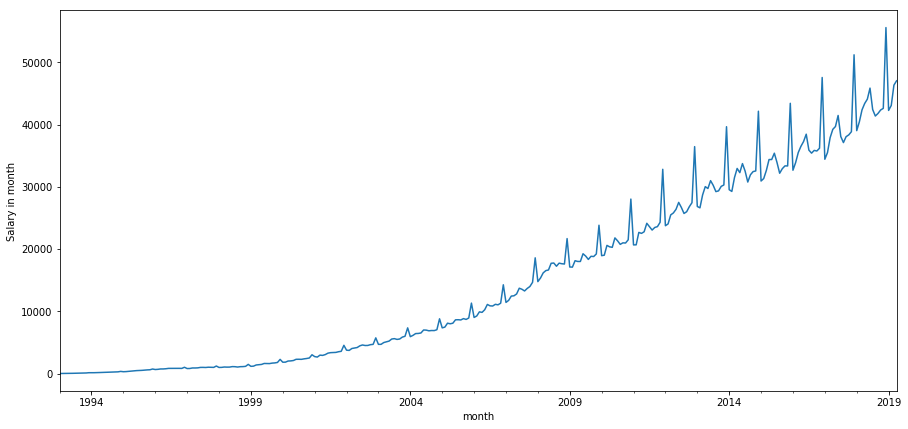

In [3]:
plt.figure(figsize(15,7))
salary.salary.plot()
plt.ylabel('Salary in month')
pylab.show()

Verify the stationarity and STL-decomposition of the series:

0.9985665683949412

<Figure size 1080x720 with 0 Axes>

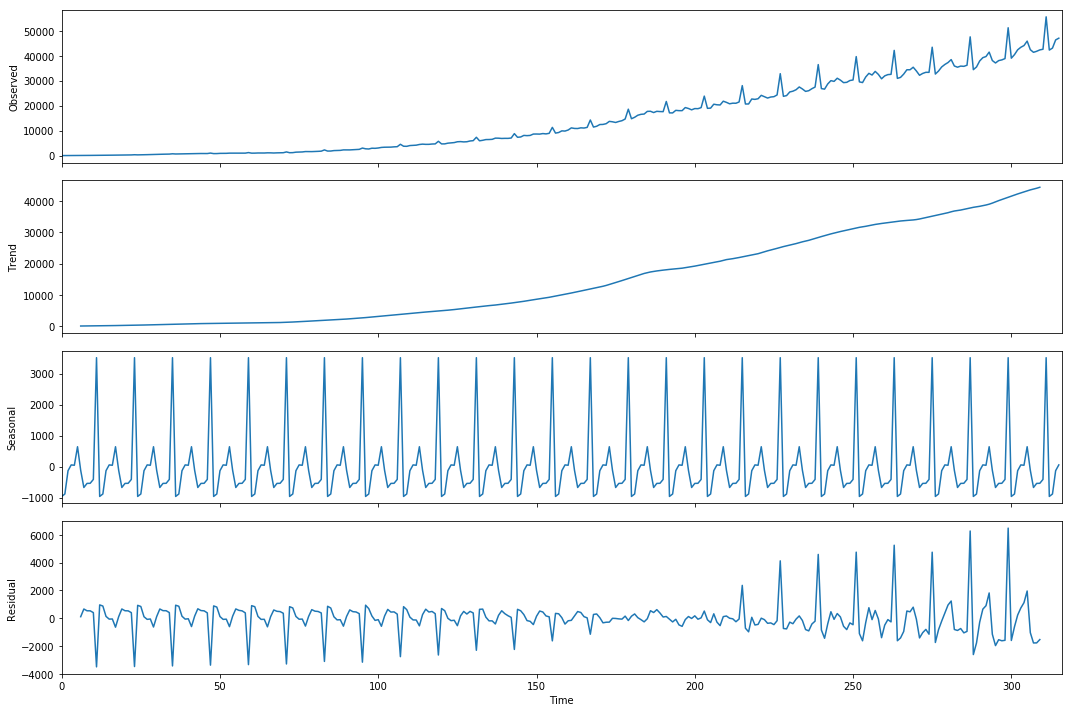

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary.values, freq=12).plot()
sm.tsa.stattools.adfuller(salary.salary)[1]

How we can see there is a trend and seasonality. Try to stabilize dispersion by the box-cox method:

0.2847461519064491
0.7339089846511575


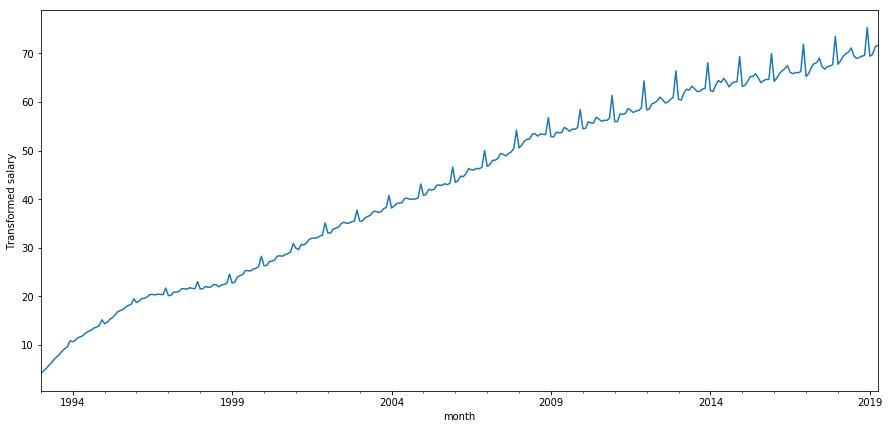

In [5]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel('Transformed salary')
print(lmbda)
print(sm.tsa.stattools.adfuller(salary.salary_box)[1])

The plot shows that the trend and seasonality are saved. Try to apply the seasonal differentiation, then check stationarity and if it is preserved we'll apply differentiation again:

In [6]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
print(sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

0.13014397701653102


In [7]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)

8.398962833463165e-10


<Figure size 1080x720 with 0 Axes>

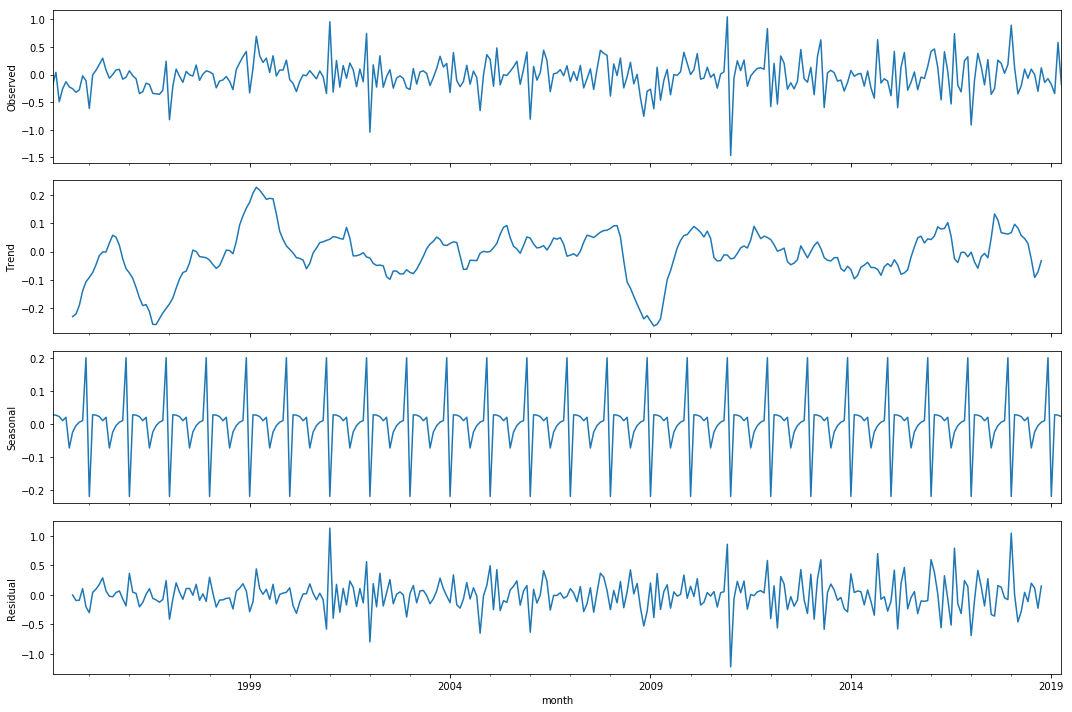

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:], freq=12).plot()
print(sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

After all the manipulations, the nonstationarity hypothesis is rejected, and the series visually looks better - there is no longer a trend.

#### Model selection
Look at ACF and PACF of new series:

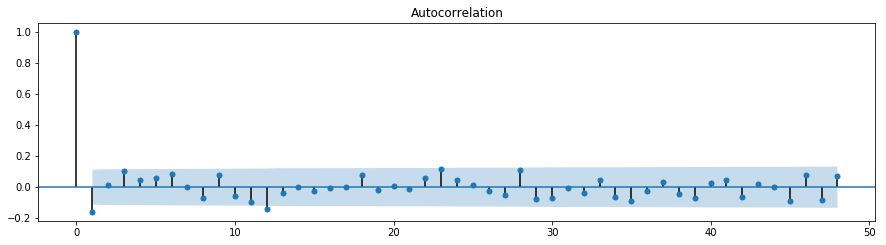

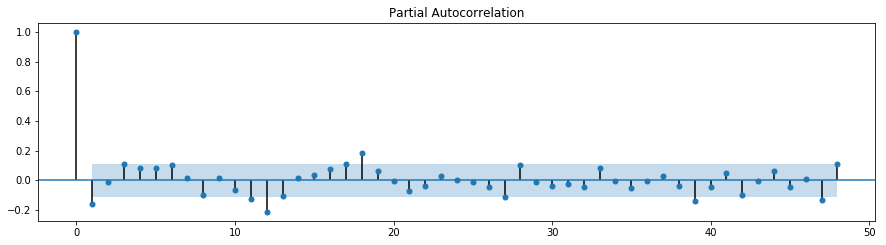

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

initial approximations Q = 1, q = 2, P = 1, p = 4

In [10]:
ps = range(0, 5)
d=1
qs = range(0, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save the best model
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
50  (2, 3, 1, 0)  104.707522
54  (2, 4, 1, 0)  105.217913
66  (3, 3, 1, 0)  105.240941
49  (2, 3, 0, 1)  105.244229
53  (2, 4, 0, 1)  105.605845


In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  316
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                 -45.354
Date:                            Wed, 19 Jun 2019   AIC                            104.708
Time:                                    09:41:58   BIC                            130.704
Sample:                                01-01-1993   HQIC                           115.108
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7167      0.084     20.381      0.000       1.552       1.882
ar.L2         -0.8387      0.076   

Student's criteria: 0.34402118180467345
Dickie-Fuller criteria: 7.06791453619555e-30


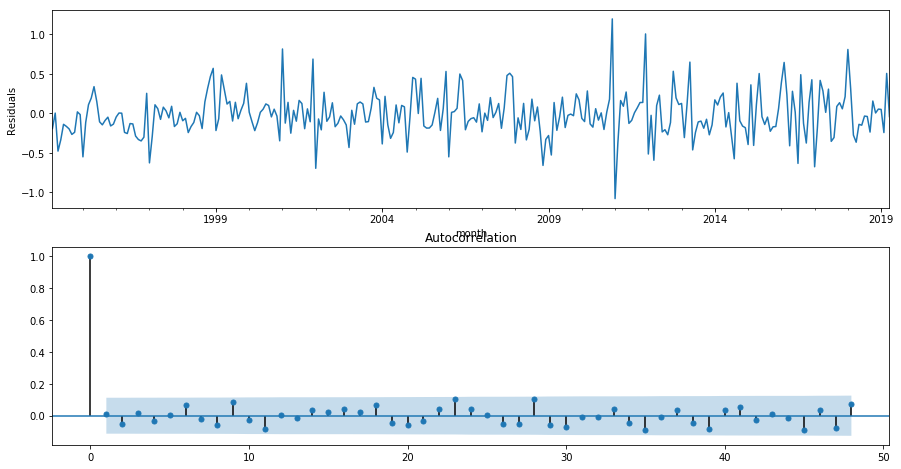

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criteria:", stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickie-Fuller criteria:", sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Build a plot with initial series and predicted data (blue - initial data, red - predicted data):

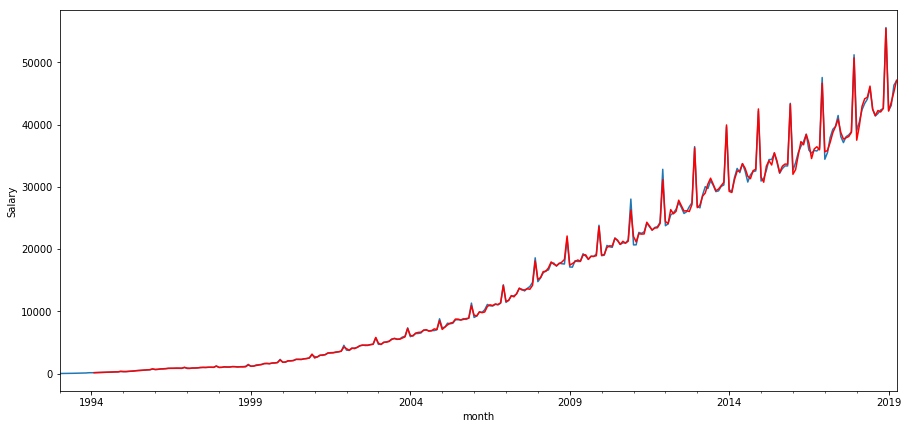

In [15]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.salary.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

How we can see, two lines are almost the same.
And finally, build a graph with the initial data and its continuation with the forecast:

/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/luda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


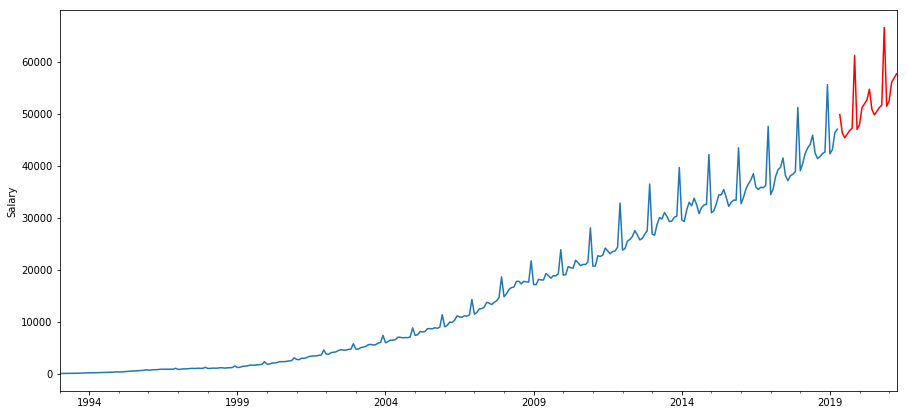

In [16]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("2019-05-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2["forecast"] = np.nan
future['forecast'] = list(invboxcox(best_model.predict(start=317, end=340), lmbda).values)
salary2 = pd.concat([salary2, future])

plt.figure(figsize(15,7))
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()